# IIVP - Project 1
### 6252320 - Leon Debnath

Import the required modules for the notebook

In [217]:
from sklearn.preprocessing import normalize
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

In [159]:
def display(images, labels, axis='off', cmap=None, figsize=(15,10), cols=2):
    
    if len(images) != len(labels):
        raise Exception("images and labels don't correspond")
        
    fig = plt.figure(figsize=figsize)
    rows = math.ceil(len(images)/cols)
    
    for i in range(len(images)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(labels[i])
        plt.axis(axis)

# Exercise 1 - Image Degradation and Motion Blur

## 1.1 Degrading & Additive Noise

### 1.1.1 - Motion Blurring

In [324]:
def blur_channel(c, a, b):
    height, width = c.shape
    c_fft = np.fft.fft2(c)
    [u, v] = np.mgrid[-round(height/2):round(height/2), -round(width/2):round(width/2)]
    u = 2 * u / height
    v = 2 * v / width
    h = np.sinc((u*a + v*b)) * np.exp(-1j * np.pi * (u*a + v*b))
    return np.abs(np.fft.ifft2(c_fft * h))


def blur(img, a, b):
    (c1, c2, c3) = cv2.split(img)
    c1_ = blur_channel(c1, a, b)
    c2_ = blur_channel(c2, a, b)
    c3_ = blur_channel(c3, a, b)
    img_blurred = cv2.merge((c1_, c2_, c3_))
    return img_blurred / np.max(img_blurred)

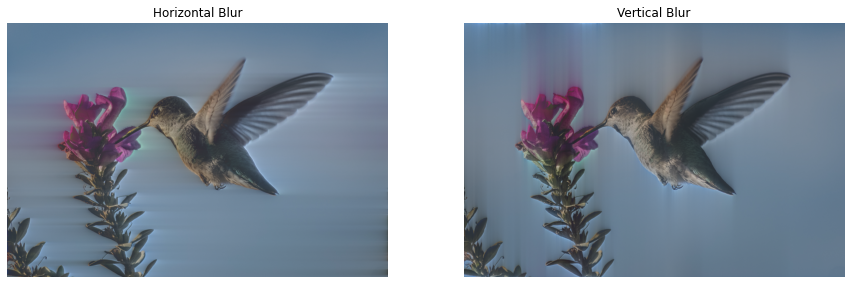

In [332]:
img = cv2.cvtColor(cv2.imread('images/bird.jpg'), cv2.COLOR_BGR2RGB)
img = img/255

img_blurred_h = blur(img, 0, 0.15)
img_blurred_v = blur(img, 0.15, 0)

display([img_blurred_h, img_blurred_v], ['Horizontal Blur', 'Vertical Blur'])

### 1.1.2 - Gaussian Noise

In [356]:
def f_noise(img):
    fft_ = np.fft.fft2(img)
    z = np.zeros(fft_.shape)
    r = random_noise(z, "gaussian", mean=0, var=0.1)
    i = random_noise(z, "gaussian", mean=0, var=0.1)
    c = np.vectorize(complex)(r, i)
    fft_c = np.add(fft_, c)

    return abs(np.fft.ifft2(fft_c))

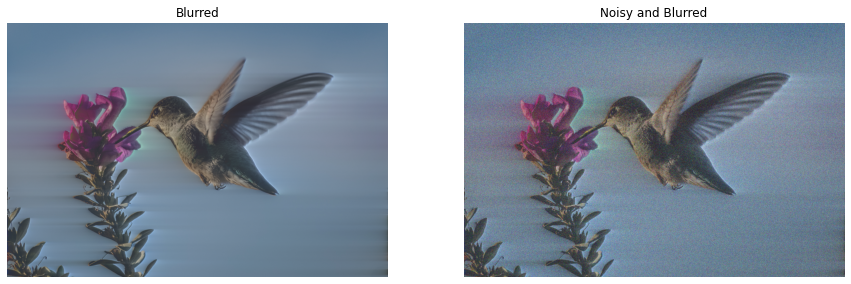

In [378]:
img_gaussian = random_noise(img_blurred, "gaussian", mean=0, var=0.04)
# img_gaussian = f_noise(img)

display([img_blurred, img_gaussian], ['Blurred', 'Noisy and Blurred'])

### 1.1.3 - Display Images

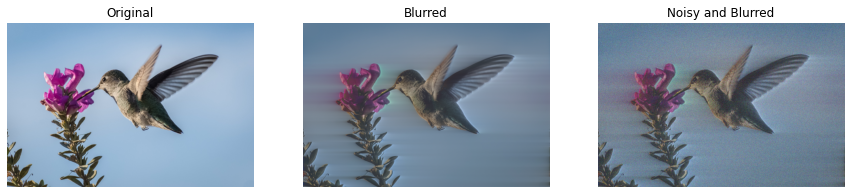

In [379]:
display([img, img_blurred, img_gaussian], ['Original', 'Blurred', 'Noisy and Blurred'], cols=3)

## 2.1 - Removing Noise

In [380]:
def inv_blur_channel(c, a, b):
    height, width = c.shape
    c_fft = np.fft.fft2(c)    
    [u, v] = np.mgrid[-round(height / 2):round(height / 2), -round(width / 2):round(width / 2)]
    u = 2 * u / height
    v = 2 * v / width
    h = np.sinc((u * a + v * b)) * np.exp(-1j * np.pi * (u * a + v * b))
    return np.abs(np.fft.ifft2(c_fft / h))

def inv_blur(img, a, b):
    (c1, c2, c3) = cv2.split(img)
    c1_ = inv_blur_channel(c1, a, b)
    c2_ = inv_blur_channel(c2, a, b)
    c3_ = inv_blur_channel(c3, a, b)
    img_blurred = cv2.merge((c1_, c2_, c3_))
    return img_blurred / np.max(img_blurred)


### 2.1.1 - Inverse Blur Filtering

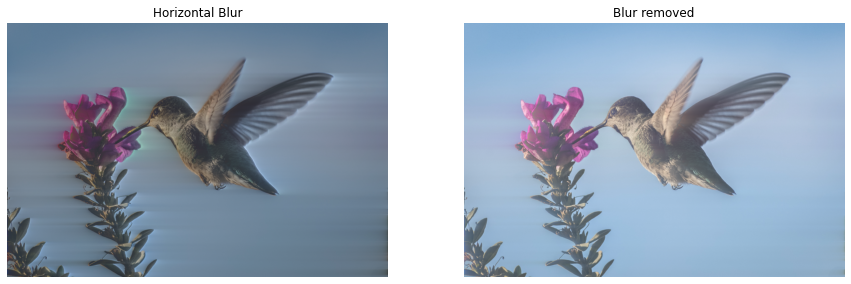

In [381]:
inv_blur_h = inv_blur(img_blurred_h, 0, 0.15)

display([img_blurred_h, inv_blur_h], ['Horizontal Blur', 'Blur removed'])

### 2.1.2 - Inverse Blur Filtering with Noise

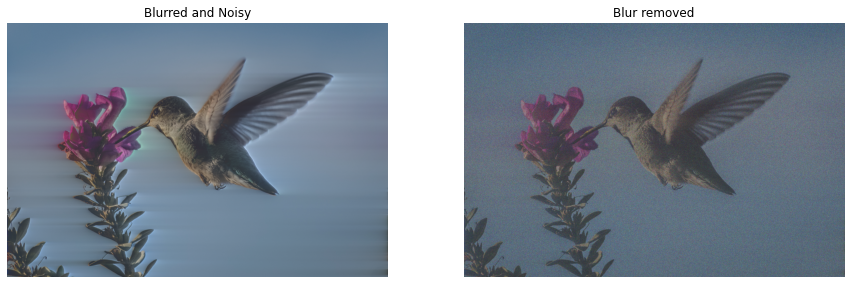

In [382]:
inv_blur_h = inv_blur(img_gaussian, 0, 0.15)

display([img_blurred_h, inv_blur_h], ['Blurred and Noisy', 'Blur removed'])

### 2.1.3 - MMSE Filter

In [387]:
def wfilter_channel(chl_o, chl_n, k_ratio):

    o_fft = np.fft.fftshift(np.fft.fft2(chl_o))
    o_pwr_spectrum = np.abs(o_fft) ** 2
    
    n_fft = np.fft.fftshift(np.fft.fft2(chl_n))
    n_pwr_spectrum = np.abs(n_fft) ** 2
    
    if k_ratio:
        k = np.sum(n_pwr_spectrum) / np.sum(o_pwr_spectrum)
    else:
        k = 1
        
    fft_combined = np.fft.fftshift(np.fft.fft2(chl_o + chl_n)) 
    img_back_fft = fft_combined / (1 + ((n_pwr_spectrum / o_pwr_spectrum) * k))
    img_back = np.fft.ifft2(img_back_fft)
    
    return np.abs(img_back)


def wfilter(img_o, img_n, k_ratio=False):
    
    (c1, c2, c3) = cv2.split(img_o)
    (n1, n2, n3) = cv2.split(img_n)
    c1_ = wfilter_channel(c1, n1, k_ratio)
    c2_ = wfilter_channel(c2, n2, k_ratio)
    c3_ = wfilter_channel(c3, n3, k_ratio)
    img = cv2.merge((c1_, c2_, c3_))
    return img / np.max(img)



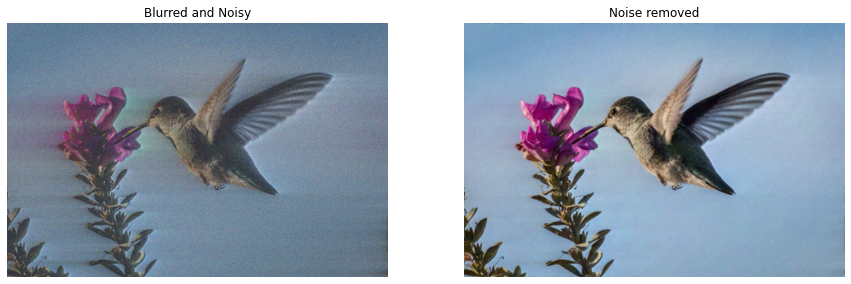

In [388]:
display([img_gaussian, wfilter(img, img_gaussian)], ['Blurred and Noisy', 'Noise removed'])

## Exercise 2

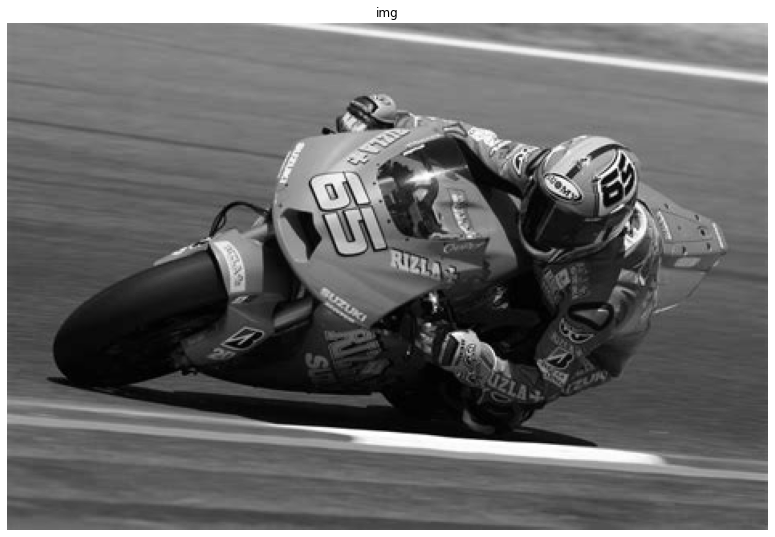

In [3]:
from scipy import fftpack
from numpy import pi
from numpy import r_

img = cv2.cvtColor(cv2.imread('images/motogp.jpeg'), cv2.COLOR_BGR2GRAY)

display([img],['img'], cmap='gray', figsize=(30,10))

## 2.1 Watermark Insertion

In [4]:
def dct2(a):
    return fftpack.dct( fftpack.dct( a.T, norm='ortho' ).T, norm='ortho' )


def dct(img, block_size=8):
    
    dct = np.zeros(img.shape)

    for i in r_[:img.shape[0]: block_size]:
        for j in r_[:img.shape[1]: block_size]:
            dct[i: i + block_size, j: j + block_size] = dct2(img[i:i+ block_size, j: j+ block_size])
            
    return dct

In [5]:
def idct2(a):
    return fftpack.idct( fftpack.idct( a.T , norm='ortho').T,norm='ortho')        
        
def idct(img_dct, block_size=8):
    
    img = np.zeros(img_dct.shape)
    
    for i in r_[:img.shape[0]: block_size]:
        for j in r_[:img.shape[1]: block_size]:
            img[i:(i + block_size), j:(j + block_size)] = idct2( img_dct[i:(i + block_size),j:(j + block_size)])
    
    return img

In [6]:
def apply_threshold(img_dct, threshold):
    
    return img_dct * (abs(img_dct) > (threshold * np.max(img_dct)))
    

In [7]:
def filter_k(block, k):
    """ Return the K (absolute) largest values in the same location as found in the block """
    oput = np.zeros(block.shape)
    block_abs = np.abs(block)
    
    for i in range(k):
        r, c = np.unravel_index(np.argmax(block_abs, axis=None), block_abs.shape)
        oput[r,c] = block[r,c]
        block_abs[r,c] = 0;
        
    return oput
        
def filter_k_highest(img_dct, k, block_size=8):
    oput = np.zeros(img_dct.shape)
    
    for i in r_[:img_dct.shape[0]: block_size]:
        for j in r_[:img_dct.shape[1]: block_size]:
            oput[i:(i + block_size), j:(j + block_size)] = filter_k(img_dct[i:(i + block_size),j:(j + block_size)], k)
    
    return oput

### 2.1.1 - Compute the 2-D DCT

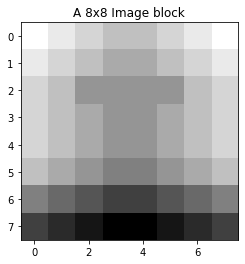

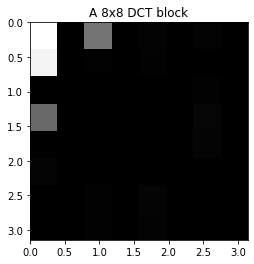

In [8]:
pos = 0
block_size=8

img_dct = dct(img)

# Extract a block from image
plt.figure()
plt.imshow(img[pos: pos + block_size, pos: pos + block_size], cmap='gray')
plt.title(f"A {block_size}x{block_size} Image block")

# Display the dct of that block
plt.figure()
plt.imshow(img_dct[pos: pos + block_size, pos: pos + block_size],
           cmap='gray',
           vmax=np.max(img_dct) * 0.01,
           vmin=0,
           extent=[0,pi,pi,0])

plt.title(f"A {block_size}x{block_size} DCT block");

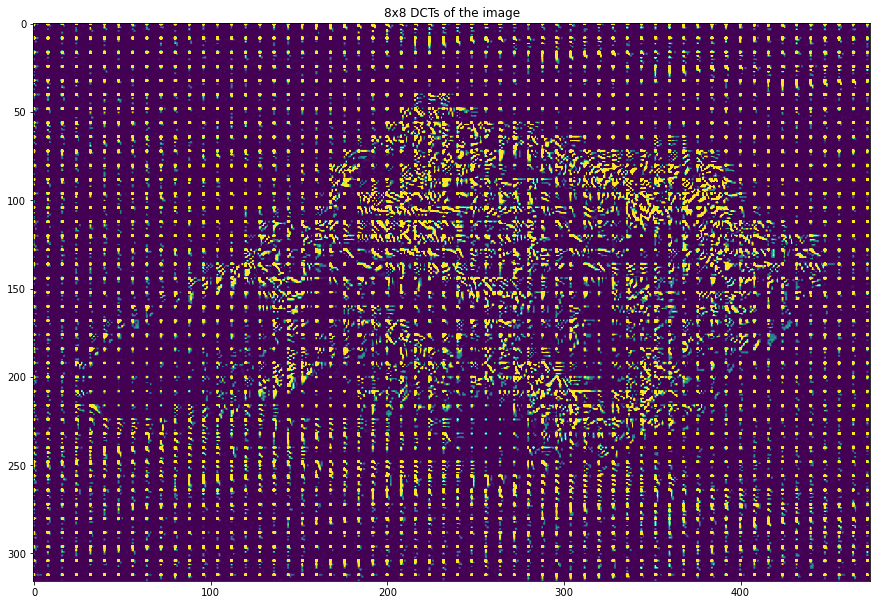

In [9]:
# Display entire DCT
plt.figure(figsize=(15,15))
plt.imshow(img_dct, vmax = np.max(img_dct)*0.01, vmin = 0)
plt.title( "8x8 DCTs of the image");

### 2.1.2 - Choose the $K$ Largest Coeficients 

In [10]:
x = [x * 0.0005 for x in range(1, 50)]
thresholds = {}
coeficients = {}

for key in x:
    thresholds[key] = apply_threshold(img_dct, key)
    coeficients[key] = 100 * np.sum(thresholds[key] != 0.0 ) / (img.shape[0] * img.shape[1] * 1.0)
    
# keys = list(thresholds.keys())
# imgs = list(thresholds.values())
# display(imgs, keys, cmap='gray', figsize=(15,25))

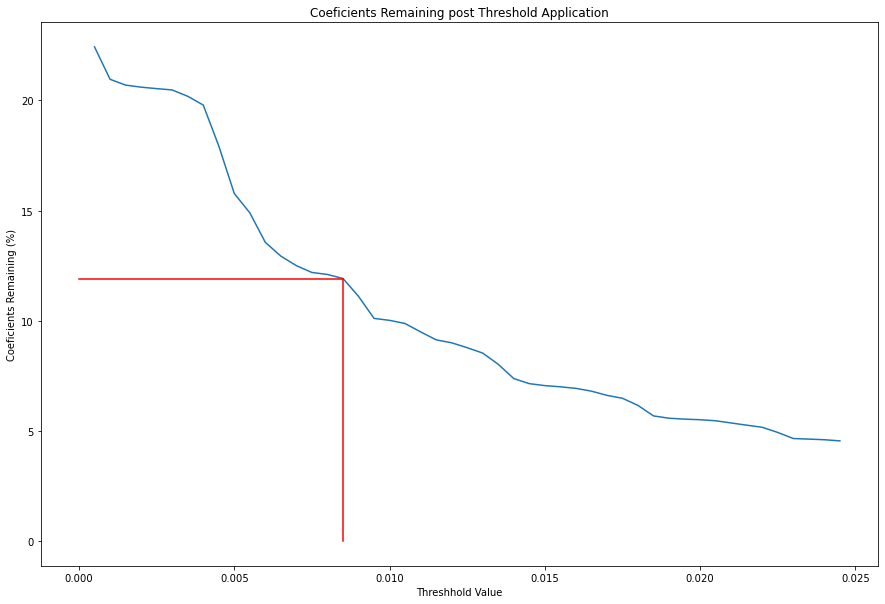

In [11]:
plt.figure(figsize=(15,10))
plt.plot(list(coeficients.keys()), list(coeficients.values()))
plt.plot([0.0085, 0.0085],[0, 11.9], 'r')
plt.plot([0, 0.0085],[11.9, 11.9], 'r')
plt.title('Coeficients Remaining post Threshold Application')
plt.xlabel('Threshhold Value')
plt.ylabel('Coeficients Remaining (%)');

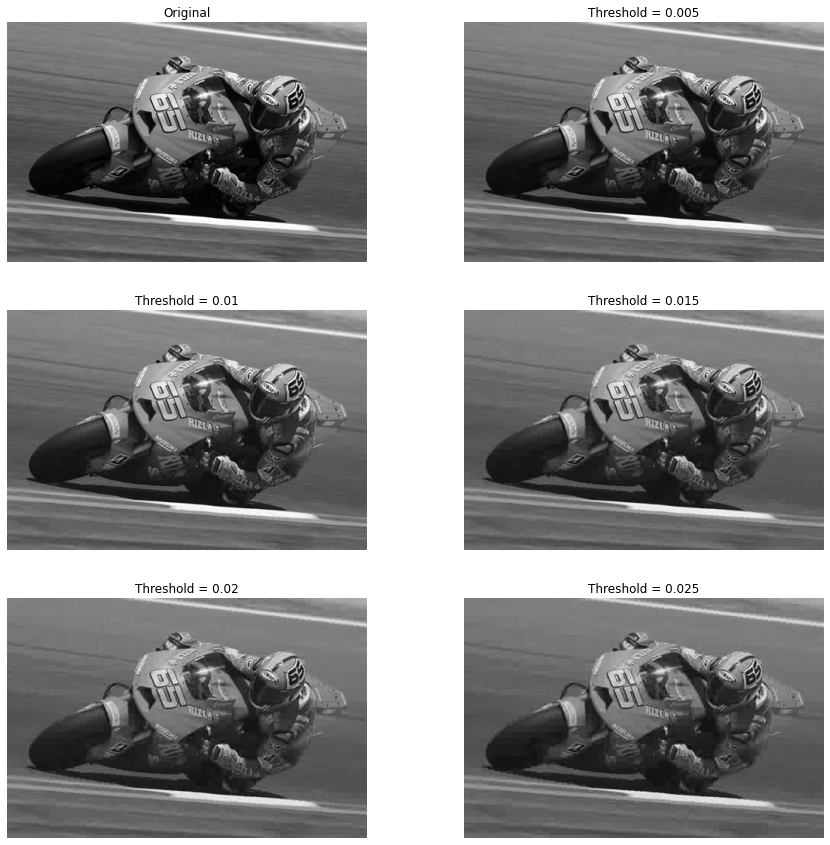

In [12]:
transformed = idct(apply_threshold(img_dct, 0.001))

display([img, 
         idct(apply_threshold(img_dct, 0.005)),
         idct(apply_threshold(img_dct, 0.01)),
         idct(apply_threshold(img_dct, 0.015)),
         idct(apply_threshold(img_dct, 0.02)),
         idct(apply_threshold(img_dct, 0.025))],
        ['Original',
         'Threshold = 0.005',
         'Threshold = 0.01',
         'Threshold = 0.015',
         'Threshold = 0.02',
         'Threshold = 0.025'],
        figsize=(15,15),
        cmap='gray')

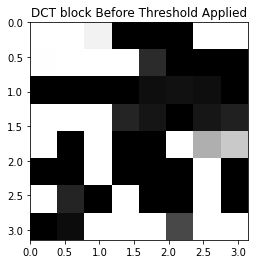

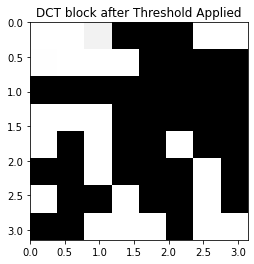

In [13]:
x_pos = 100
y_pos = 200
block_size=8

img_dct = dct(img)

# Display the dct of that block
plt.figure()
plt.imshow(img_dct[x_pos: x_pos + block_size, y_pos: y_pos + block_size],
           cmap='gray',
           vmax=np.max(img_dct) * 0.01,
           vmin=0,
           extent=[0,pi,pi,0])
plt.title(f"DCT block Before Threshold Applied");

img_dct_t = apply_threshold(img_dct, 0.0085)

# Display the dct of that block
plt.figure()
plt.imshow(img_dct_t[x_pos: x_pos + block_size, y_pos: y_pos + block_size],
           cmap='gray',
           vmax=np.max(img_dct) * 0.01,
           vmin=0,
           extent=[0,pi,pi,0])

plt.title(f"DCT block after Threshold Applied");

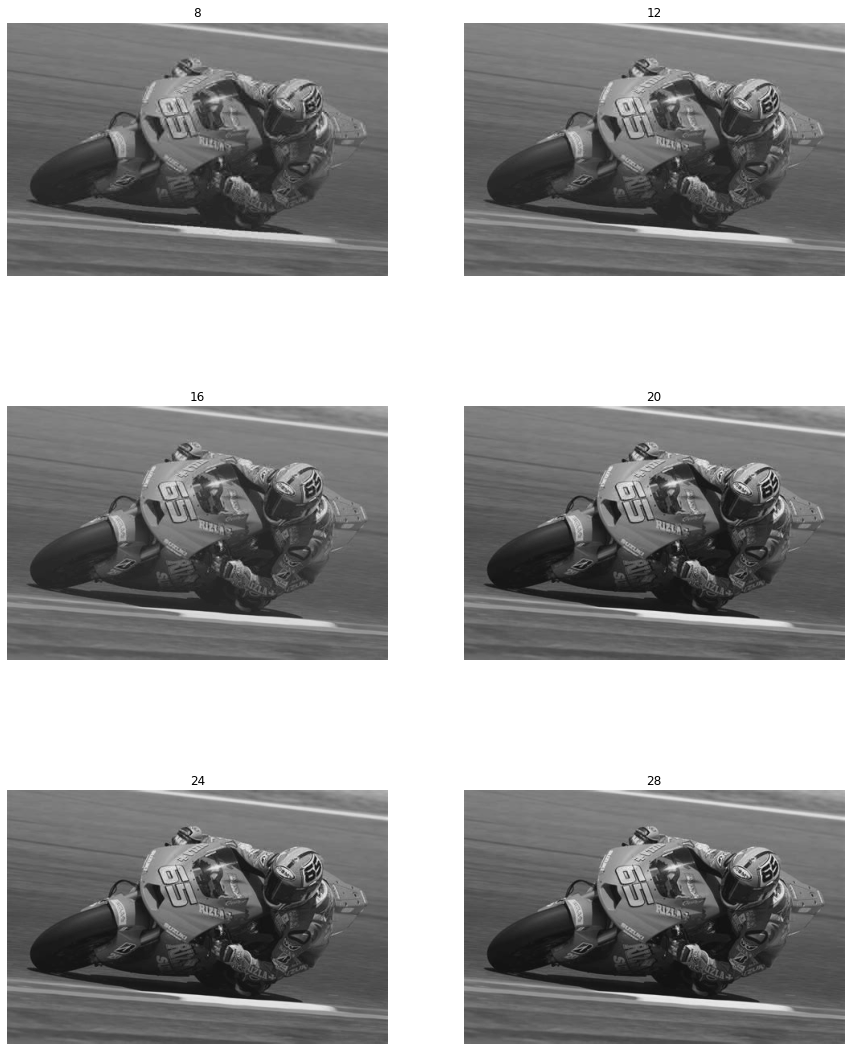

In [14]:
K = [n for n in range(8,32,4)]

images = {}

for k in K:
    images[k] = idct(filter_k_highest(img_dct, k))
    
values = list(images.values())
keys = list(images.keys())
display(values, keys, cmap='gray', figsize=(15, 20))


### 2.1.3 - Create a watermark

In [15]:
k = 32
mu = 0
sigma = 1
alpha = 0.1

w = np.random.default_rng().normal(size=(k,))
print(w)

[ 0.12141336 -0.74714453  0.06445213  1.68480218 -0.19493352 -1.19595478
 -2.95671364  1.28711035 -0.98291959  0.16603071  1.08944113 -0.39683493
  0.97993627  0.90241043 -2.49304376 -0.98317868  0.15581401  0.01387795
  0.32387592  0.02056436  0.76184947  1.72277978  0.333618   -0.16148545
  1.83313572  0.57899358 -2.66723684 -0.74472997 -1.37198947 -0.09976199
  0.43954017 -2.34010595]


### 2.1.4 - Embed a Watermark

In [16]:
def watermark_block(block, w):
    oput = np.zeros(block.shape)
    block_abs = np.abs(block)
    
    for w_i in w:
        r, c = np.unravel_index(np.argmax(block_abs, axis=None), block_abs.shape)
        oput[r,c] = block[r,c] * (1 + alpha * w_i)
        block_abs[r,c] = 0;
    
    oput[0,0] = block[0,0]     
    return oput
        
def watermark(img_dct, w, block_size=8):
    oput = np.zeros(img_dct.shape)
    
    for i in r_[:img_dct.shape[0]: block_size]:
        for j in r_[:img_dct.shape[1]: block_size]:
            oput[i:(i + block_size), j:(j + block_size)] = watermark_block(img_dct[i:(i + block_size),j:(j + block_size)], w)
    
    return oput

### 2.1.5 - Create the Watermarked DCT

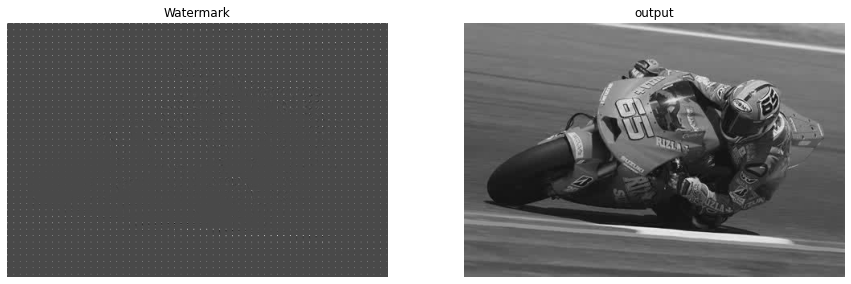

In [17]:
img_w = watermark(img_dct_t, w)

display([img_w, idct(img_w)],['Watermark', 'output'], cmap='gray')

### 2.1.6 - Comparison

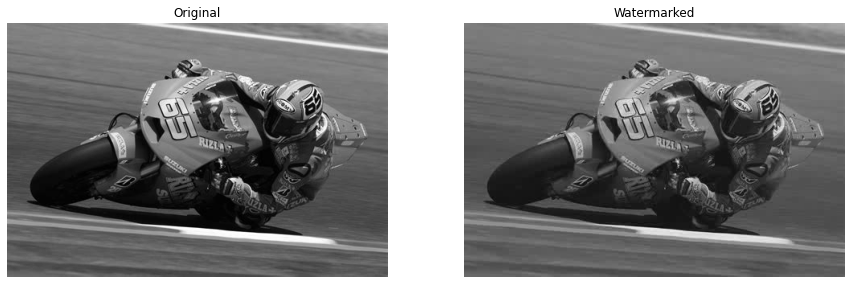

In [18]:
display([img, idct(img_w)], ['Original', 'Watermarked'], cmap='gray')

### 2.1.7 - Histogram

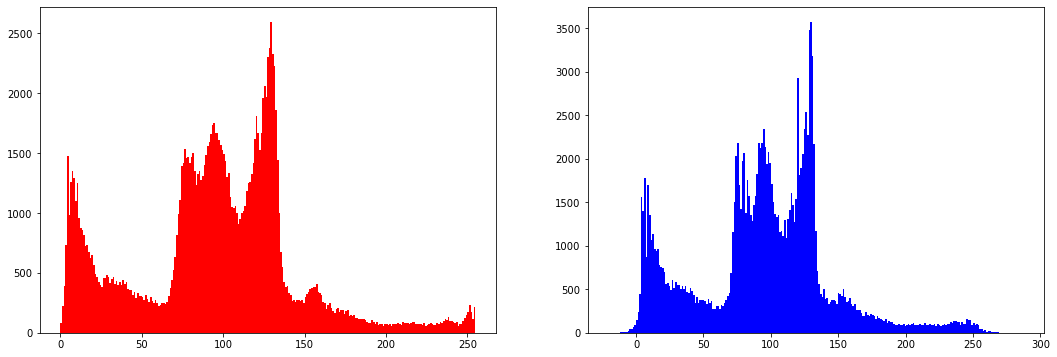

In [19]:
img_flattened = np.reshape(img, (img.shape[0] * img.shape[1],))
w_flattened = np.reshape(idct(img_w), (img_w.shape[0] * img_w.shape[1],))

fig = plt.figure(figsize=(18,6))
fig.add_subplot(1, 2, 1)
plt.hist(img_flattened, bins=255, color='red');
fig.add_subplot(1, 2, 2)
plt.hist(w_flattened, bins=255, color='blue');

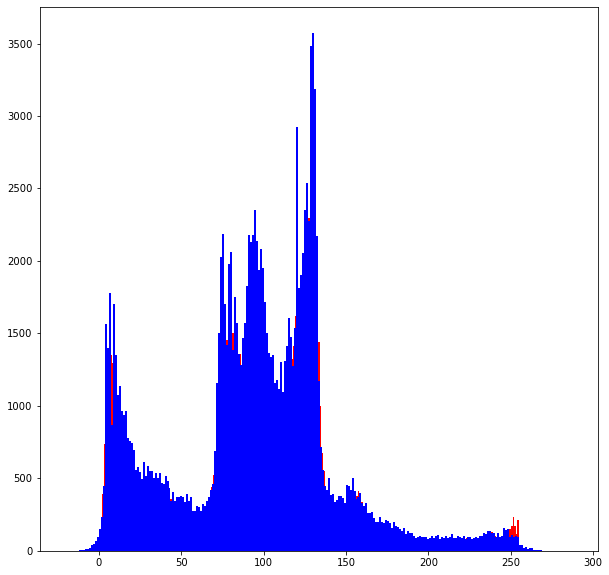

In [20]:
plt.figure(figsize=(10,10))
plt.hist(img_flattened, bins=255, color='red');
plt.hist(w_flattened, bins=255, color='blue');

### 2.1.8 - DC Coefficient
TODO - Explain

## 2.2 - Watermark Detection

### 2.2.1 - Compute the 2D DCT

In [21]:
mystery_1 = img
mystery_2 = idct(img_w)
m1_dct = dct(mystery_1)
m2_dct = dct(mystery_2)

## 2.2.2 - Keep the K largest non-DC coefficients

In [22]:
def remove_DC(img_dct):
    oput = img_dct
    
    for i in r_[:img_dct.shape[0]: block_size]:
        for j in r_[:img_dct.shape[1]: block_size]:
            
            oput[i, j] = 0
    
    return oput

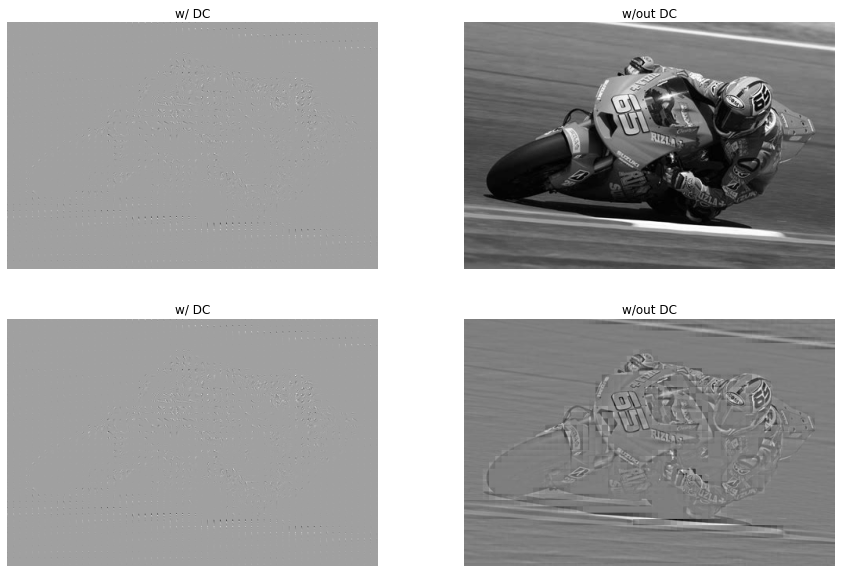

In [23]:
dc_less = remove_DC(m1_dct)
display([m1_dct, mystery_1, dc_less, idct(dc_less)],['w/ DC', 'w/out DC', 'w/ DC', 'w/out DC'], cmap='gray')

In [24]:
m1_dct_filtered = filter_k_highest(m1_dct, k)
m2_dct_filtered = filter_k_highest(m2_dct, k)

In [25]:
def compare_block(c_hat, c, k):
    w_hat = []
    c_hat = np.abs(c_hat)
    c_act = np.abs(c)
    
    c_hat[0, 0] = 0
    
    for i in range(k):
        r, c = np.unravel_index(np.argmax(c_hat, axis=None), c_hat.shape)
        
        denom = (alpha * c_act[r, c])
        numer = (c_hat[r, c] - c_act[r, c])
        
        if denom != 0:
            w_hat.append(numer/denom)
        else:
            w_hat.append(0)
                 
        c_hat[r, c] = 0
              
    return w_hat

In [26]:
def estimate_watermark(img_a, img_b, k, block_size=8):
    w_hat = []
    
    for i in r_[:img_dct.shape[0]: block_size]:
        for j in r_[:img_dct.shape[1]: block_size]:
            
            c_hat = img_a[i:(i + block_size),j:(j + block_size)]
            c = img_b[i:(i + block_size),j:(j + block_size)]
            
            w_i = compare_block(c_hat, c, k)
            w_hat.append(w_i)
    
    return np.asarray(w_hat)

In [27]:
w_hats = estimate_watermark(m1_dct_filtered, m2_dct_filtered, k)
print(w_hats.shape)

np.max(w_hats)

(2400, 32)


1.36053442936123e+19

In [28]:
w

array([ 0.12141336, -0.74714453,  0.06445213,  1.68480218, -0.19493352,
       -1.19595478, -2.95671364,  1.28711035, -0.98291959,  0.16603071,
        1.08944113, -0.39683493,  0.97993627,  0.90241043, -2.49304376,
       -0.98317868,  0.15581401,  0.01387795,  0.32387592,  0.02056436,
        0.76184947,  1.72277978,  0.333618  , -0.16148545,  1.83313572,
        0.57899358, -2.66723684, -0.74472997, -1.37198947, -0.09976199,
        0.43954017, -2.34010595])

# 3 - Morphology

## 3.1 - Count Oranges

### Pre-processing


# 4 - Principal Component Analysis Recognition

## 4.1 - Eigenfaces

In [389]:
# PCA Steps:

# 1. Format the data into a matrix of points where each is a vector [x, y, z] (M_data)

# 2. Calculate the Mean vector  (x_mean)

# 3. Subtract Mean from data matrix  (M = M_data - x_mean)

# 4. Calculate the Covariance matrix  (C = M * M ^T)

# 5. Calculate the Eigen vectors and Eigen values of the covariance matrix

Images have dimensions:  height = 900px , width = 600px, channels = 3


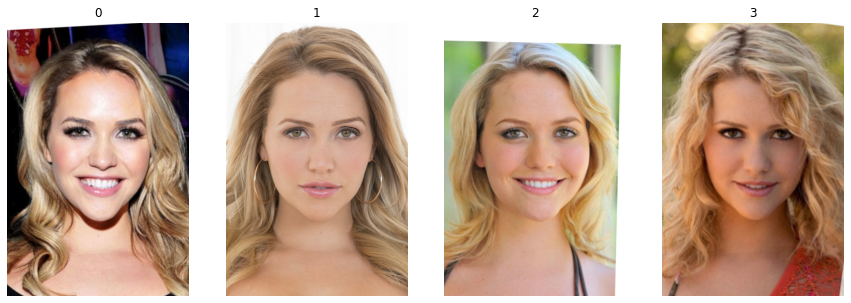

In [161]:
import glob

faces = []

for filename in glob.glob('faces_aligned/face2*.jpeg'):
    faces.append(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))

height, width, channels = faces[0].shape

print(f"Images have dimensions:  height = {height}px , width = {width}px, channels = {channels}")
display(faces, [i for i in range(len(faces))], cols=4)

In [144]:
# 1. Format the data into a matrix of points where each image is a vector of m * n (900 * 600)   
lst = []

for face in faces:
    m, n, c = face.shape
    lst.append(np.reshape(face, m * n * c))
    
M_data = np.stack(lst, axis=0)
M_data = M_data / 255
print(M_data.shape)
print(np.max(M_data))
print(np.min(M_data))

(4, 1620000)
1.0
0.0


In [145]:
# 2. Calculate the Mean vectors
mean = np.mean(M_data, axis=0)
print(mean)
print(mean.shape)
print(np.max(mean))
print(np.min(mean))

[0.92352941 0.91960784 0.90784314 ... 0.80686275 0.72647059 0.65588235]
(1620000,)
0.9980392156862745
0.05784313725490196


In [146]:
# 3. Subtract Mean from data matrix  (M = M_data - x_mean)
M_data = np.subtract(M_data, mean)
M_data.shape

(4, 1620000)

In [147]:
# 4. Calculate the Covariance matrix  (C = M * M ^T)
C = np.dot(M_data, M_data.T)

In [148]:
# 5. Calculate the Eigen vectors and Eigen values of the covariance matrix
m, eigen_vectors = np.linalg.eig(C)

In [149]:
m, eigen_vectors = cv2.PCACompute(M_data, mean=None, maxComponents=10)

print(f"Mean vector shape: {mean.shape}")
print(f"Mean vector max: {np.max(mean)}")
print(f"Mean vector min: {np.min(mean)}\n")

print(f"Eigen Vectors shape: {eigen_vectors.shape}")
print(f"Eigen Vectors max: {np.max(eigen_vectors)}")
print(f"Eigen Vectors min: {np.min(eigen_vectors)}\n")
print(eigen_vectors)

Mean vector shape: (1620000,)
Mean vector max: 0.9980392156862745
Mean vector min: 0.05784313725490196

Eigen Vectors shape: (4, 1620000)
Eigen Vectors max: 0.0033377415196004074
Eigen Vectors min: -0.003257387817442098

[[ 4.18326433e-05  4.32575716e-05  4.75323566e-05 ... -3.57166732e-04
  -4.02204408e-04 -5.43492156e-04]
 [-9.40057026e-04 -9.91174261e-04 -1.14452597e-03 ... -4.96340339e-05
  -7.02549561e-05 -1.89008580e-05]
 [ 3.03780814e-04  3.23689958e-04  3.83417392e-04 ... -1.19043452e-03
  -1.83596152e-03 -2.33403563e-03]
 [-5.06741962e-04 -5.30968670e-04 -6.05667684e-04 ... -1.31732721e-04
  -3.09899965e-04 -3.30088888e-04]]


### 4.1 - Show the resulting eigenfaces and explain their apperance

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


There are 4 eigen faces


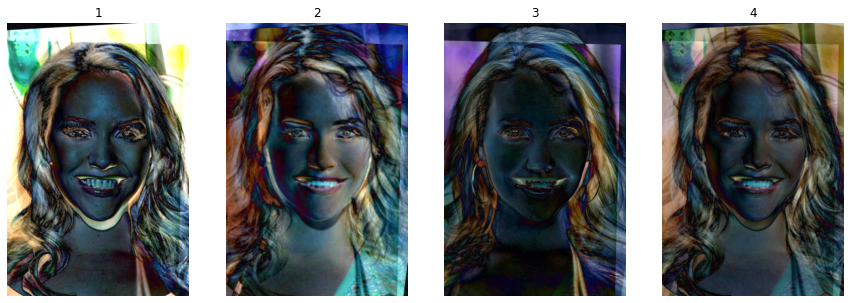

In [162]:
# Reshape EigenVectors to obtain EigenFaces
eig_faces = [np.reshape(e, (height, width, channels)) for e in eigen_vectors]

print(f"There are {len(eig_faces)} eigen faces")

display([ np.abs(f) / np.max(f) for f in eig_faces], [i+1 for i in range(len(faces))], cols=4)

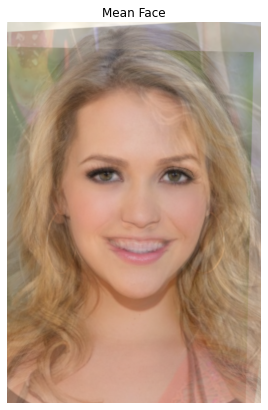

In [152]:
mean_face = np.reshape(mean, (height, width, channels))

display([mean_face],['Mean Face'], figsize=(10,15))

### 4.2.1 - Reconstruct Faces with all Eigenfaces

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


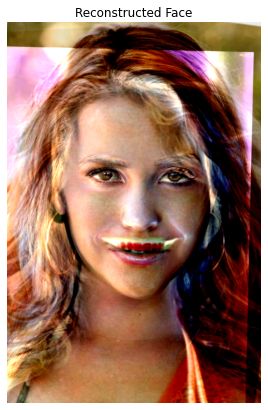

In [405]:
output = mean_face

weights = [0 for i in range(len(eig_faces))]
weights[0] = 255
weights[1] = 255
weights[2] = 255
weights[3] = 255


for i, weight in enumerate(weights):
    output = np.add(output, np.multiply(eig_faces[i], weight))

display([output],['Reconstructed Face'], figsize=(10,15))

### 4.2.2 - Reconstruct Faces with few Eigenfaces

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


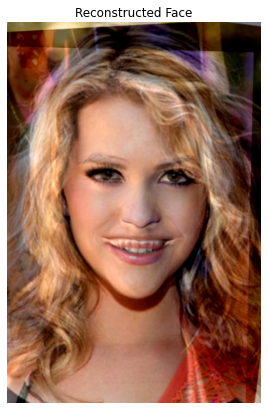

In [408]:
output = mean_face

weights = [0 for i in range(len(eig_faces))]
weights[0] = 255
weights[1] = 255
weights[2] = 0
weights[3] = 0


for i, weight in enumerate(weights):
    output = np.add(output, np.multiply(eig_faces[i], weight))

display([output],['Reconstructed Face'], figsize=(10,15))